# Fine tune DNN parameters

### Note that you have to execute the first 4 cells and then you can execute each part of this notebook separately

This notebook's aim is to find appropriate parameters for the implemented deep neural network which optimize training speed and Sharpe ratio. We experiment with the first 7 months of data (6 months for training and 1 month for testing) as this will be the rolling window used in the final strategy.

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload


In [2]:
# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())

In [3]:
daily = pd.read_csv("Targets/daily_crsp_sanitized.csv", nrows = 2000000)
daily['date'] = pd.to_datetime(daily['date'], format = "%Y-%m-%d")
daily = daily[daily['date'] >= '2000-01-31'] # Start at the end of January to align with predictors data
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
158482,2000-01-31,5,15580,6320,0,-0.068182,0.025218
158483,2000-01-31,7,14593,3573,0,0.020910,0.025218
158484,2000-01-31,25,62770,6711,0,0.041045,0.025218
158485,2000-01-31,29,59184,2082,0,0.011236,0.025218
158486,2000-01-31,33,59248,2082,0,0.034667,0.025218
...,...,...,...,...,...,...,...
1999995,2000-12-13,16265,86321,6310,0,0.057471,-0.008161
1999996,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161
1999997,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161
1999998,2000-12-13,16268,86339,4899,0,0.009456,-0.008161


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

158482     2000-01
166811     2000-02
333239     2000-03
524367     2000-04
682344     2000-05
865365     2000-06
1048421    2000-07
1214853    2000-08
1407308    2000-09
1573891    2000-10
1756726    2000-11
1930059    2000-12
Name: year_month, dtype: period[M]

In [5]:
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df)

In [6]:
train_df

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_lag2,DlyRet_lag3,DlyRet_lag4,DlyRet_lag5
158482,2000-01-31,15580,786,-0.068182,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158483,2000-01-31,14593,399,0.020910,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158484,2000-01-31,62770,812,0.041045,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158485,2000-01-31,59184,110,0.011236,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158486,2000-01-31,59248,110,0.034667,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
...,...,...,...,...,...,...,...,...,...,...
1048416,2000-06-30,15912,818,-0.013158,0.008465,-0.012987,0.026667,0.000000,0.027397,0.000000
1048417,2000-06-30,79191,43,0.018018,0.008465,0.037383,0.023923,-0.066964,-0.062762,0.012712
1048418,2000-06-30,78671,544,-0.070423,0.008465,0.105058,-0.062044,-0.098684,-0.006536,-0.012903
1048419,2000-06-30,17337,316,0.000000,0.008465,-0.032967,0.000000,0.000000,0.011111,-0.032258


In [7]:
test_df

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_lag2,DlyRet_lag3,DlyRet_lag4,DlyRet_lag5
1048421,2000-07-03,15580,770,0.011494,0.010271,-0.001005,-0.000148,0.000634,0.000977,0.001162
1048422,2000-07-03,14593,388,0.017900,0.010271,-0.001005,-0.000148,0.000634,0.000977,0.001162
1048423,2000-07-03,62770,796,0.055556,0.010271,-0.001005,-0.000148,0.000634,0.000977,0.001162
1048424,2000-07-03,59184,108,0.020921,0.010271,-0.001005,-0.000148,0.000634,0.000977,0.001162
1048425,2000-07-03,59248,108,0.020661,0.010271,-0.001005,-0.000148,0.000634,0.000977,0.001162
...,...,...,...,...,...,...,...,...,...,...
1214848,2000-07-31,15912,802,0.013514,0.007705,-0.013333,0.013514,-0.013333,0.000000,0.013514
1214849,2000-07-31,79191,41,0.013953,0.007705,-0.027149,0.037559,-0.049107,-0.034483,-0.016949
1214850,2000-07-31,78671,529,0.012007,0.007705,-0.013536,-0.001689,-0.010033,0.006734,-0.041935
1214851,2000-07-31,17337,307,0.012500,0.007705,0.012658,-0.059524,-0.045455,0.000000,-0.022222


## First run: 50 epochs, default learning rate, 5 days of past returns 

In [8]:
train_losses, test_losses, train_sharpes, test_sharpes = utils.train_DNN(train_df, test_df, features, cat_features)

Starting training with 435 train batches, 41 test batches


Training:   2%|▋                                 | 1/50 [00:14<11:41, 14.33s/it]

Epoch 1/50, Loss: -0.0248, Train Sharpe: 0.0595, Test Sharpe: 0.0341


Training:  22%|███████▎                         | 11/50 [02:51<10:45, 16.55s/it]

Epoch 11/50, Loss: -0.1596, Train Sharpe: 0.1720, Test Sharpe: 0.1315


Training:  42%|█████████████▊                   | 21/50 [05:37<07:57, 16.47s/it]

Epoch 21/50, Loss: -0.1760, Train Sharpe: 0.1873, Test Sharpe: 0.1281


Training:  62%|████████████████████▍            | 31/50 [08:19<05:25, 17.11s/it]

Epoch 31/50, Loss: -0.1826, Train Sharpe: 0.1952, Test Sharpe: 0.1281


Training:  82%|███████████████████████████      | 41/50 [11:04<02:31, 16.80s/it]

Epoch 41/50, Loss: -0.1869, Train Sharpe: 0.1993, Test Sharpe: 0.1263


Training: 100%|█████████████████████████████████| 50/50 [13:36<00:00, 16.32s/it]

Epoch 50/50, Loss: -0.1877, Train Sharpe: 0.2012, Test Sharpe: 0.1264
Training completed! Best test Sharpe ratio: 0.1347


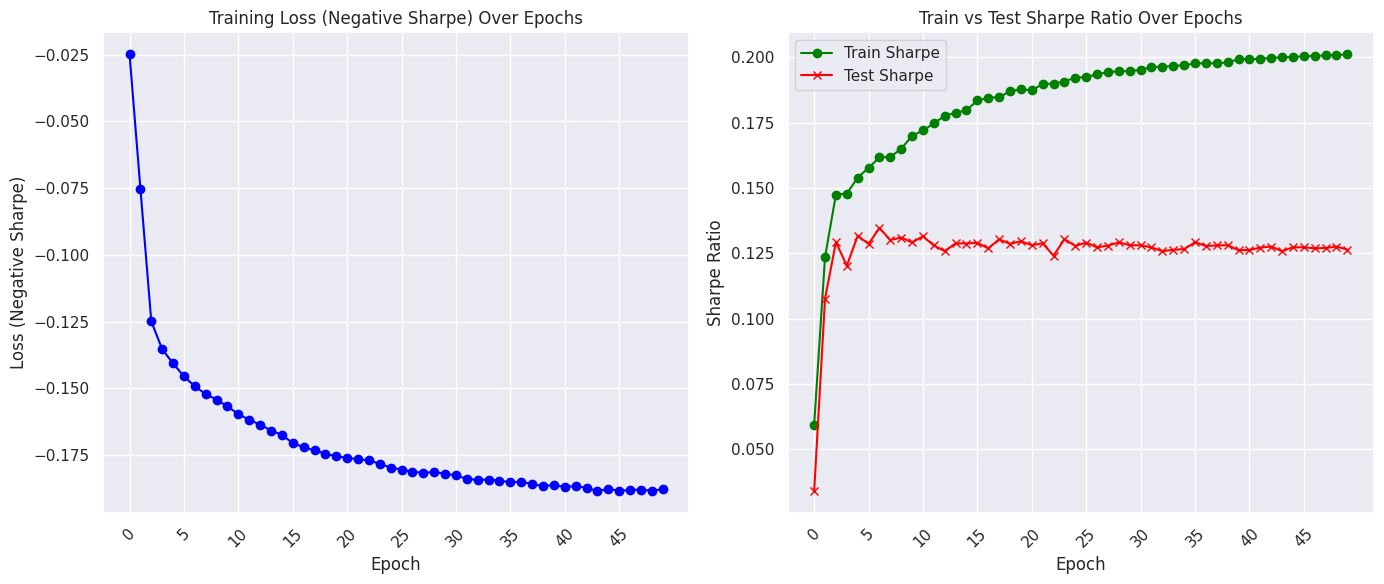

In [9]:
reload(utils)
epochs = 50
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

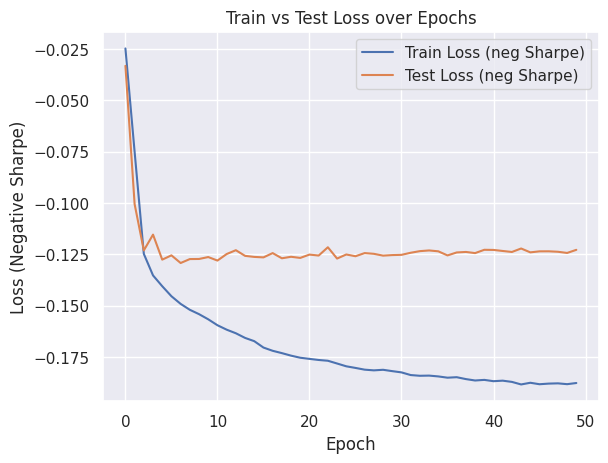

In [10]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

## Second run: increase learning rate, reduce epochs

It seems a high number of epochs isn't necessary for convergence. Actually, it reduces out of sample Sharpe ratio as it overfits the training data. We can train faster using less epochs and a higher learning rate. The above plots suggest 3 epochs is sufficient. However, since this is quite low, we first try with 10 and a faster learning rate of 0.01 instead of 0.001.

In [14]:
train_df

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_lag2,DlyRet_lag3,DlyRet_lag4,DlyRet_lag5
158482,2000-01-31,15580,786,-0.068182,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158483,2000-01-31,14593,399,0.020910,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158484,2000-01-31,62770,812,0.041045,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158485,2000-01-31,59184,110,0.011236,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158486,2000-01-31,59248,110,0.034667,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
...,...,...,...,...,...,...,...,...,...,...
1048416,2000-06-30,15912,818,-0.013158,0.008465,-0.012987,0.026667,0.000000,0.027397,0.000000
1048417,2000-06-30,79191,43,0.018018,0.008465,0.037383,0.023923,-0.066964,-0.062762,0.012712
1048418,2000-06-30,78671,544,-0.070423,0.008465,0.105058,-0.062044,-0.098684,-0.006536,-0.012903
1048419,2000-06-30,17337,316,0.000000,0.008465,-0.032967,0.000000,0.000000,0.011111,-0.032258


In [16]:
reload(utils)

<module 'DNN_utils' from '/home/mirko/user/ML/Project/DNN_utils.py'>

In [7]:
train_losses, test_losses, train_sharpes, test_sharpes = utils.train_DNN(train_df, test_df, features, cat_features, epochs=10, learning_rate=0.01)

Using 4 workers for data loading
PyTorch using 16 CPU threads
Using device: cpu
Starting CPU-optimized training...
Train batches: 435, Test batches: 41
Batch sizes - Train: 2048, Test: 4096
Effective batch size with accumulation: 4096
Model compiled for CPU optimization


Training:  10%|███▍                              | 1/10 [00:30<04:32, 30.29s/it]

Epoch 1/10, Loss: -0.0622, Train Sharpe: 0.1307, Test Sharpe: 0.1052, LR: 0.010000


Training:  40%|█████████████▌                    | 4/10 [01:17<01:56, 19.42s/it]

Epoch 4/10, Loss: -0.1629, Train Sharpe: 0.1767, Test Sharpe: 0.1048, LR: 0.010000


Training:  70%|███████████████████████▊          | 7/10 [02:01<00:51, 17.19s/it]

Epoch 7/10, Loss: -0.1782, Train Sharpe: 0.1901, Test Sharpe: 0.1088, LR: 0.010000


Training: 100%|█████████████████████████████████| 10/10 [02:49<00:00, 16.90s/it]

Epoch 10/10, Loss: -0.1834, Train Sharpe: 0.1965, Test Sharpe: 0.1181, LR: 0.010000
Training completed!
Best test Sharpe ratio: 0.1181


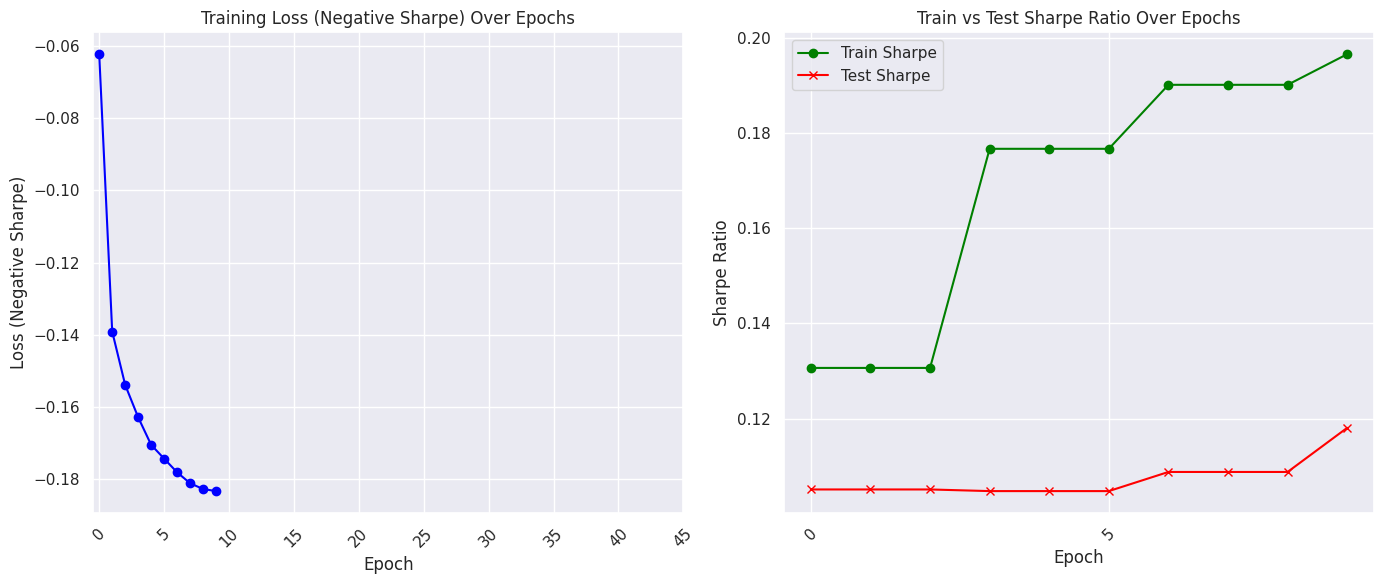

In [9]:
epochs=10
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

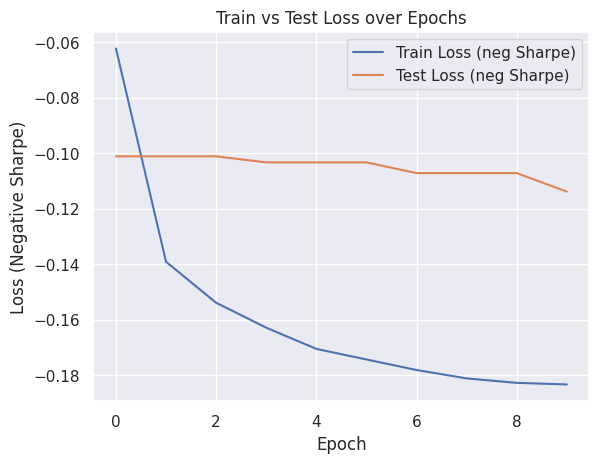

In [10]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

## Third run: use only 1 day lagged returns, not 1 to 5 and compare Sharpe ratio

It seems that increasing the learning rate by a factor of 10 before slightly lowered the maximal Sharpe ratio, so we'll keep it at 0.001 default value. 

In [7]:
reload(utils)
# Retrain with only 1 day lagged returns 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()
train_df_1, test_df_1, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1)

In [8]:
train_df_1

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1
158482,2000-01-31,15580,786,-0.068182,0.025218,0.000661
158483,2000-01-31,14593,399,0.020910,0.025218,0.000661
158484,2000-01-31,62770,812,0.041045,0.025218,0.000661
158485,2000-01-31,59184,110,0.011236,0.025218,0.000661
158486,2000-01-31,59248,110,0.034667,0.025218,0.000661
...,...,...,...,...,...,...
1048416,2000-06-30,15912,818,-0.013158,0.008465,-0.012987
1048417,2000-06-30,79191,43,0.018018,0.008465,0.037383
1048418,2000-06-30,78671,544,-0.070423,0.008465,0.105058
1048419,2000-06-30,17337,316,0.000000,0.008465,-0.032967


In [9]:
test_df_1

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1
1048421,2000-07-03,15580,770,0.011494,0.010271,-0.001005
1048422,2000-07-03,14593,388,0.017900,0.010271,-0.001005
1048423,2000-07-03,62770,796,0.055556,0.010271,-0.001005
1048424,2000-07-03,59184,108,0.020921,0.010271,-0.001005
1048425,2000-07-03,59248,108,0.020661,0.010271,-0.001005
...,...,...,...,...,...,...
1214848,2000-07-31,15912,802,0.013514,0.007705,-0.013333
1214849,2000-07-31,79191,41,0.013953,0.007705,-0.027149
1214850,2000-07-31,78671,529,0.012007,0.007705,-0.013536
1214851,2000-07-31,17337,307,0.012500,0.007705,0.012658


In [11]:
train_losses, test_losses, train_sharpes, test_sharpes = utils.train_DNN(train_df_1, test_df_1, features, cat_features, epochs=10)

Using 4 workers for data loading
PyTorch using 16 CPU threads
Using device: cpu
Starting CPU-optimized training...
Train batches: 435, Test batches: 41
Batch sizes - Train: 2048, Test: 4096
Effective batch size with accumulation: 4096
Model compiled for CPU optimization


Training:  10%|███▍                              | 1/10 [00:44<06:38, 44.24s/it]

Epoch 1/10, Loss: -0.0150, Train Sharpe: 0.0247, Test Sharpe: -0.0078, LR: 0.001000


Training:  40%|█████████████▌                    | 4/10 [01:29<02:04, 20.77s/it]

Epoch 4/10, Loss: -0.0986, Train Sharpe: 0.1312, Test Sharpe: 0.1112, LR: 0.001000


Training:  70%|███████████████████████▊          | 7/10 [02:13<00:53, 17.96s/it]

Epoch 7/10, Loss: -0.1325, Train Sharpe: 0.1481, Test Sharpe: 0.1278, LR: 0.001000


Training: 100%|█████████████████████████████████| 10/10 [02:59<00:00, 17.97s/it]

Epoch 10/10, Loss: -0.1430, Train Sharpe: 0.1550, Test Sharpe: 0.1244, LR: 0.001000
Training completed!
Best test Sharpe ratio: 0.1278


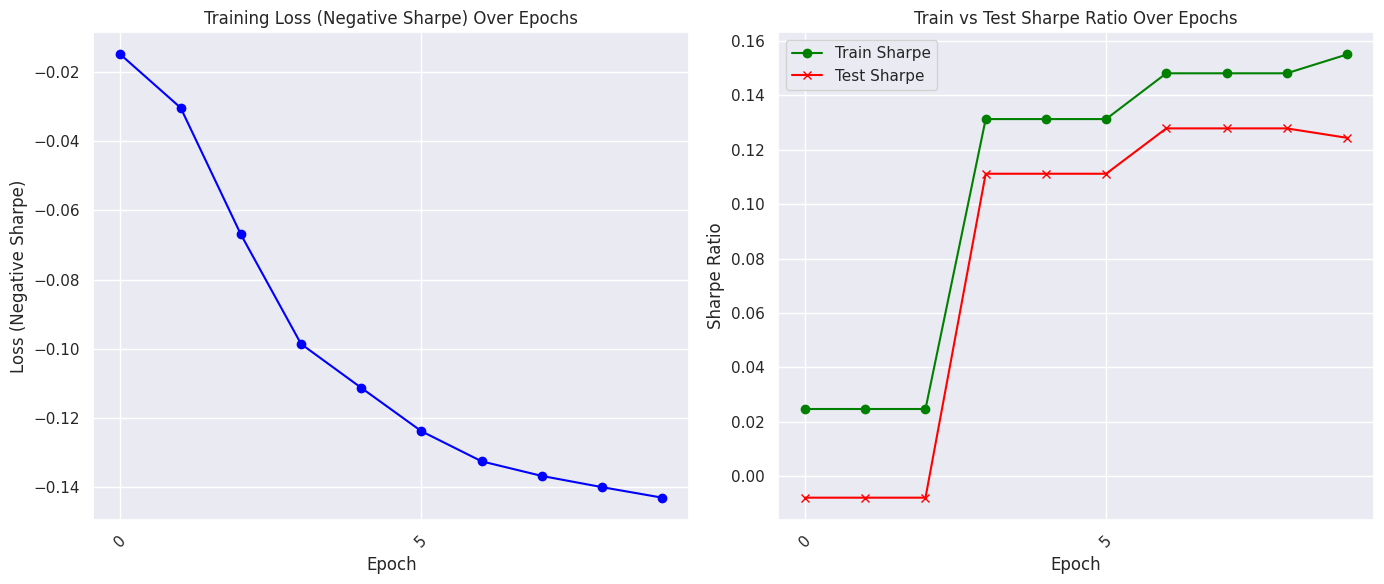

In [15]:
epochs = 10
reload(utils)
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

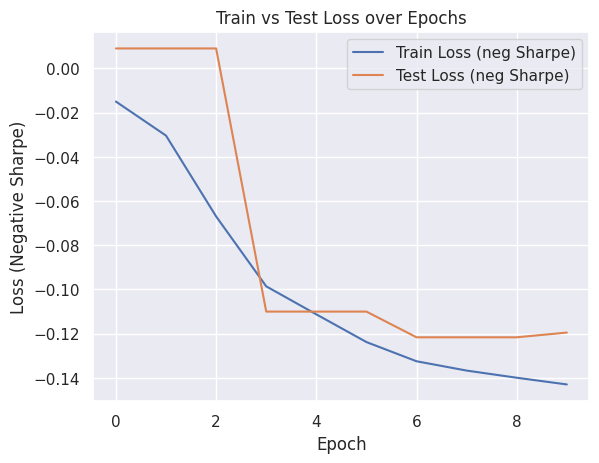

In [16]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

## Do rolling windows increase the Sharpe ratio? 

We've seen just before that using 1 day of lagged returns doesn't lower the Sharpe ratio compared to the case when we use 5 days of lagged returns. 

In [5]:
reload(utils)
# Retrain with only 1 day lagged returns and rolling windows
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()
train_df_2, test_df_2, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['DlyRet', 'sprtrn', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [6]:
train_losses, test_losses, train_sharpes, test_sharpes = utils.train_DNN(train_df_2, test_df_2, features, cat_features, epochs=10)

Starting training with 435 train batches, 41 test batches


Training:  10%|███▍                              | 1/10 [00:15<02:17, 15.26s/it]

Epoch 1/10, Loss: -0.7481, Train Sharpe: 1.7496, Test Sharpe: 1.6041


Training: 100%|█████████████████████████████████| 10/10 [02:30<00:00, 15.01s/it]

Epoch 10/10, Loss: -2.0911, Train Sharpe: 2.2403, Test Sharpe: 2.1016
Training completed! Best test Sharpe ratio: 2.1082


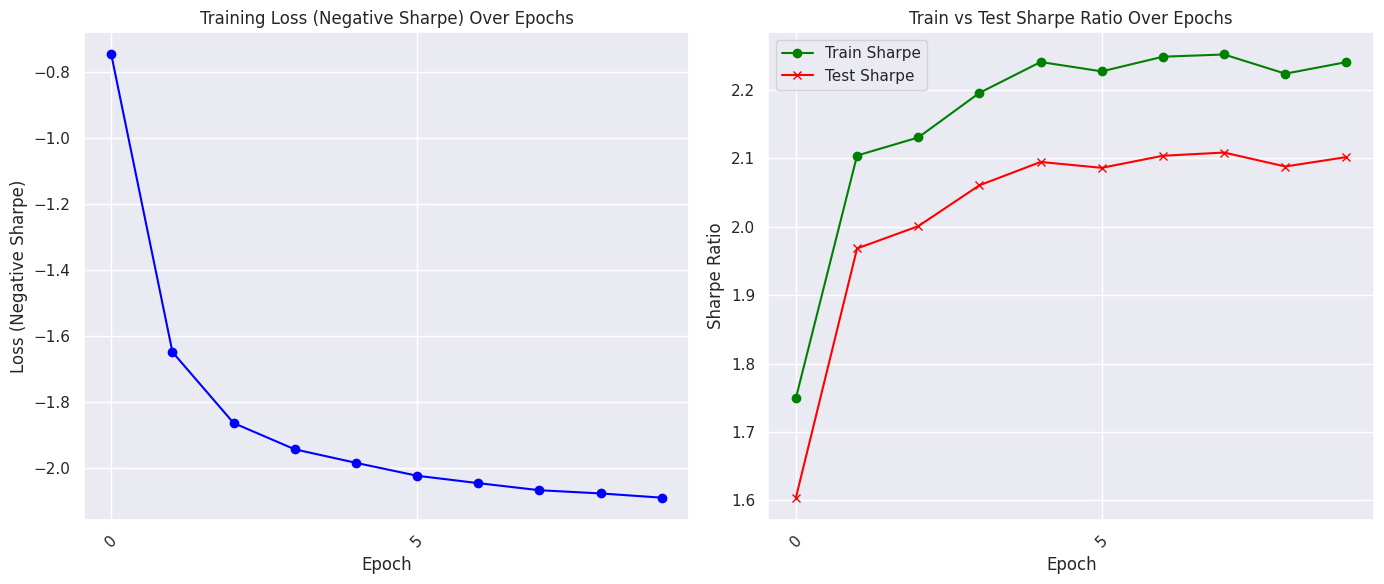

In [7]:
epochs = 10
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

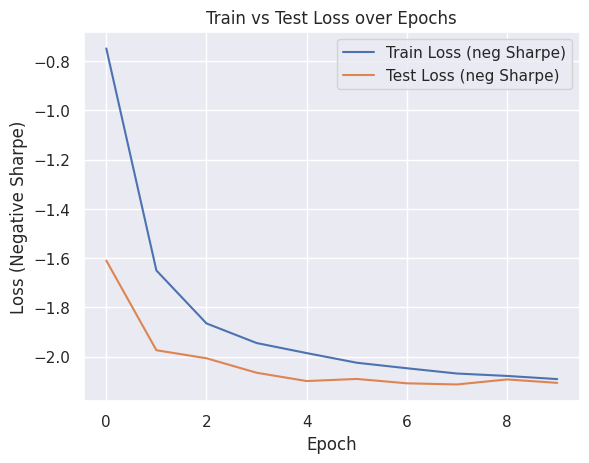

In [8]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

## Incorporate firm characteristics index

Note that rolling windows significantly increase the Sharpe ratio. Therefore, we include them in the training of our DNN. Now that we have fine-tuned the model, let us include the index built from firm characteristics.

In [5]:
index_df = pd.read_csv('Predictors/FirmCharacIndex.csv')
index_df

,Unnamed: 0,date,PERMNO,gvkey,pls_index
0,0,2000-01-31,10025,11903,-3.107469
1,1,2000-01-31,10089,12143,-1.304217
2,2,2000-01-31,10155,12094,-2.892794
3,3,2000-01-31,10182,12171,5.863377
4,4,2000-01-31,10256,12226,-3.608628
...,...,...,...,...,...
520167,520167,2024-12-31,93426,185138,-0.052260
520168,520168,2024-12-31,93427,179583,3.371618
520169,520169,2024-12-31,93429,184500,5.908846
520170,520170,2024-12-31,93434,184259,-4.831854


In [6]:
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,year_month
158482,2000-01-31,5,15580,6320,0,-0.068182,0.025218,2000-01
158483,2000-01-31,7,14593,3573,0,0.020910,0.025218,2000-01
158484,2000-01-31,25,62770,6711,0,0.041045,0.025218,2000-01
158485,2000-01-31,29,59184,2082,0,0.011236,0.025218,2000-01
158486,2000-01-31,33,59248,2082,0,0.034667,0.025218,2000-01
...,...,...,...,...,...,...,...,...
1999995,2000-12-13,16265,86321,6310,0,0.057471,-0.008161,2000-12
1999996,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161,2000-12
1999997,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161,2000-12
1999998,2000-12-13,16268,86339,4899,0,0.009456,-0.008161,2000-12


In [7]:
def merge_pls_with_asof(daily_returns, pls_data):
    """
    Merge PLS index data to daily returns using merge_asof with forward filling.
    
    This function handles the sorting requirements properly and processes each
    PERMNO separately to avoid sorting issues with merge_asof.
    
    Parameters:
    -----------
    daily_returns : DataFrame
        Daily returns data with columns: date, PERMNO, DlyRet, etc.
    pls_data : DataFrame  
        Monthly PLS index data with columns: date, PERMNO, pls_index
    
    Returns:
    --------
    DataFrame
        Merged dataframe with forward-filled pls_index values
    """
    
    # Make copies to avoid modifying original data
    daily_df = daily_returns.copy()
    pls_df = pls_data.copy()
    
    # Ensure date columns are datetime
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    pls_df['date'] = pd.to_datetime(pls_df['date'])
    
    # Get unique PERMNOs from both datasets
    daily_permnos = set(daily_df['PERMNO'].unique())
    pls_permnos = set(pls_df['PERMNO'].unique())
    common_permnos = daily_permnos & pls_permnos
    
    print(f"Processing {len(common_permnos)} common PERMNOs...")
    
    # Process each PERMNO separately to ensure proper sorting
    merged_parts = []
    
    for i, permno in enumerate(common_permnos):
        if i % 1000 == 0:  # Progress indicator
            print(f"Processing PERMNO {i+1}/{len(common_permnos)}")
        
        # Get data for this PERMNO and sort by date
        daily_subset = daily_df[daily_df['PERMNO'] == permno].sort_values('date')
        pls_subset = pls_df[pls_df['PERMNO'] == permno].sort_values('date')
        
        if len(pls_subset) > 0:
            # Perform merge_asof for this PERMNO
            merged_subset = pd.merge_asof(
                daily_subset,
                pls_subset[['date', 'pls_index']],
                on='date',
                direction='backward'  # Forward fill: use most recent available value
            )
            merged_parts.append(merged_subset)
    
    # Handle PERMNOs that exist in daily data but not in PLS data
    permnos_without_pls = daily_permnos - pls_permnos
    if permnos_without_pls:
        print(f"Adding {len(permnos_without_pls)} PERMNOs without PLS data...")
        for permno in permnos_without_pls:
            daily_subset = daily_df[daily_df['PERMNO'] == permno].copy()
            daily_subset['pls_index'] = np.nan
            merged_parts.append(daily_subset)
    
    # Combine all parts
    print("Combining results...")
    merged_df = pd.concat(merged_parts, ignore_index=True)
    
    # Restore original order if needed
    merged_df = merged_df.sort_values(['date', 'PERMNO']).reset_index(drop=True)
    
    return merged_df

def check_merge_quality(merged_df, original_daily_df):
    """
    Check the quality of the merge operation.
    
    Parameters:
    -----------
    merged_df : DataFrame
        Result from merge operation
    original_daily_df : DataFrame
        Original daily returns dataframe
    """
    
    print("\n" + "="*50)
    print("MERGE QUALITY REPORT")
    print("="*50)
    
    print(f"Original daily rows: {len(original_daily_df):,}")
    print(f"Merged rows: {len(merged_df):,}")
    print(f"Rows with PLS data: {merged_df['pls_index'].notna().sum():,}")
    print(f"Rows missing PLS data: {merged_df['pls_index'].isna().sum():,}")
    print(f"Coverage: {(merged_df['pls_index'].notna().sum() / len(merged_df)) * 100:.1f}%")
    
    # Check for duplicates
    duplicates = merged_df.duplicated(subset=['date', 'PERMNO']).sum()
    print(f"Duplicate (date, PERMNO) pairs: {duplicates}")
    
    # Sample check - show forward fill working
    print(f"\nSample forward fill check:")
    sample_permno = merged_df[merged_df['pls_index'].notna()]['PERMNO'].iloc[0]
    sample_data = merged_df[merged_df['PERMNO'] == sample_permno].head(10)
    print(sample_data[['date', 'PERMNO', 'DlyRet', 'pls_index']].to_string())
    
    # Check date range coverage
    print(f"\nDate range:")
    print(f"Daily data: {merged_df['date'].min()} to {merged_df['date'].max()}")
    pls_dates = merged_df[merged_df['pls_index'].notna()]['date']
    if len(pls_dates) > 0:
        print(f"PLS data: {pls_dates.min()} to {pls_dates.max()}")


# Quick test function to verify the logic
def test_merge_logic():
    """
    Test the merge logic with sample data
    """
    # Create sample data
    daily_sample = pd.DataFrame({
        'date': pd.date_range('2000-01-01', '2000-01-31', freq='D'),
        'PERMNO': [10001] * 31,
        'DlyRet': np.random.normal(0, 0.02, 31)
    })
    
    pls_sample = pd.DataFrame({
        'date': ['2000-01-01', '2000-01-15'],
        'PERMNO': [10001, 10001],
        'pls_index': [-1.5, -2.0]
    })
    pls_sample['date'] = pd.to_datetime(pls_sample['date'])
    
    # Test merge
    result = merge_pls_with_asof(daily_sample, pls_sample)
    
    print("Test Results:")
    print(result[['date', 'PERMNO', 'DlyRet', 'pls_index']].head(20))
    
    return result



In [8]:
merged_result = merge_pls_with_asof(daily, index_df)
merged_result

Processing 7849 common PERMNOs...
Processing PERMNO 1/7849
Processing PERMNO 1001/7849
Processing PERMNO 2001/7849
Processing PERMNO 3001/7849
Processing PERMNO 4001/7849
Processing PERMNO 5001/7849
Processing PERMNO 6001/7849
Processing PERMNO 7001/7849
Adding 1253 PERMNOs without PLS data...
Combining results...


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,year_month,pls_index
0,2000-01-31,7953,10001,4920,0,-0.029851,0.025218,2000-01,NaN
1,2000-01-31,7954,10002,6020,0,-0.005236,0.025218,2000-01,NaN
2,2000-01-31,7965,10009,6030,0,-0.004255,0.025218,2000-01,NaN
3,2000-01-31,7969,10012,3670,0,-0.033333,0.025218,2000-01,NaN
4,2000-01-31,1728,10016,3560,0,0.038168,0.025218,2000-01,NaN
...,...,...,...,...,...,...,...,...,...
1841513,2000-12-13,7428,92690,6798,0,0.006993,-0.008161,2000-12,0.710286
1841514,2000-12-13,7407,92807,6020,0,0.014085,-0.008161,2000-12,0.117273
1841515,2000-12-13,7378,92874,3690,0,-0.031746,-0.008161,2000-12,-0.447077
1841516,2000-12-13,7323,92930,3714,0,-0.007634,-0.008161,2000-12,4.626466


In [9]:
check_merge_quality(merged_result, daily)


MERGE QUALITY REPORT
Original daily rows: 1,841,518
Merged rows: 1,841,518
Rows with PLS data: 1,316,468
Rows missing PLS data: 525,050
Coverage: 71.5%
Duplicate (date, PERMNO) pairs: 0

Sample forward fill check:
            date  PERMNO    DlyRet  pls_index
6     2000-01-31   10025  0.025126  -3.107469
8335  2000-02-01   10025  0.019608  -3.107469
16658 2000-02-02   10025  0.030769  -3.107469
24982 2000-02-03   10025  0.000000  -3.107469
33298 2000-02-04   10025  0.007463  -3.107469
41616 2000-02-07   10025 -0.014815  -3.107469
49940 2000-02-08   10025 -0.007519  -3.107469
58251 2000-02-09   10025 -0.030303  -3.107469
66564 2000-02-10   10025 -0.003906  -3.107469
74876 2000-02-11   10025 -0.015686  -3.107469

Date range:
Daily data: 2000-01-31 00:00:00 to 2000-12-13 00:00:00
PLS data: 2000-01-31 00:00:00 to 2000-12-13 00:00:00


In [10]:
test_result = test_merge_logic()
test_result

Processing 1 common PERMNOs...
Processing PERMNO 1/1
Combining results...
Test Results:
         date  PERMNO    DlyRet  pls_index
0  2000-01-01   10001 -0.010362       -1.5
1  2000-01-02   10001  0.026667       -1.5
2  2000-01-03   10001  0.003137       -1.5
3  2000-01-04   10001  0.011178       -1.5
4  2000-01-05   10001  0.002661       -1.5
5  2000-01-06   10001  0.012180       -1.5
6  2000-01-07   10001  0.008479       -1.5
7  2000-01-08   10001  0.000437       -1.5
8  2000-01-09   10001  0.000492       -1.5
9  2000-01-10   10001 -0.000371       -1.5
10 2000-01-11   10001 -0.027041       -1.5
11 2000-01-12   10001 -0.018992       -1.5
12 2000-01-13   10001  0.004174       -1.5
13 2000-01-14   10001  0.007730       -1.5
14 2000-01-15   10001 -0.015885       -2.0
15 2000-01-16   10001  0.030455       -2.0
16 2000-01-17   10001 -0.018866       -2.0
17 2000-01-18   10001 -0.030642       -2.0
18 2000-01-19   10001  0.006501       -2.0
19 2000-01-20   10001 -0.014427       -2.0


,date,PERMNO,DlyRet,pls_index
0,2000-01-01,10001,-0.010362,-1.5
1,2000-01-02,10001,0.026667,-1.5
2,2000-01-03,10001,0.003137,-1.5
3,2000-01-04,10001,0.011178,-1.5
4,2000-01-05,10001,0.002661,-1.5
5,2000-01-06,10001,0.012180,-1.5
6,2000-01-07,10001,0.008479,-1.5
7,2000-01-08,10001,0.000437,-1.5
8,2000-01-09,10001,0.000492,-1.5
9,2000-01-10,10001,-0.000371,-1.5


In [11]:
merged_result = merged_result.fillna(0)
merged_result

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,year_month,pls_index
0,2000-01-31,7953,10001,4920,0,-0.029851,0.025218,2000-01,0.000000
1,2000-01-31,7954,10002,6020,0,-0.005236,0.025218,2000-01,0.000000
2,2000-01-31,7965,10009,6030,0,-0.004255,0.025218,2000-01,0.000000
3,2000-01-31,7969,10012,3670,0,-0.033333,0.025218,2000-01,0.000000
4,2000-01-31,1728,10016,3560,0,0.038168,0.025218,2000-01,0.000000
...,...,...,...,...,...,...,...,...,...
1841513,2000-12-13,7428,92690,6798,0,0.006993,-0.008161,2000-12,0.710286
1841514,2000-12-13,7407,92807,6020,0,0.014085,-0.008161,2000-12,0.117273
1841515,2000-12-13,7378,92874,3690,0,-0.031746,-0.008161,2000-12,-0.447077
1841516,2000-12-13,7323,92930,3714,0,-0.007634,-0.008161,2000-12,4.626466


In [12]:
reload(utils)
# Retrain with only 1 day lagged returns and rolling windows
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (merged_result['year_month'] >= train_start) & (merged_result['year_month'] <= train_end)
test_mask = merged_result['year_month'] == test_month

tr_df = merged_result[train_mask].copy()
te_df = merged_result[test_mask].copy()
train_df_3, test_df_3, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['DlyRet', 'sprtrn', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [13]:
train_df_3

,date,PERMNO,SICCD,DlyRet,sprtrn,pls_index,DlyRet_lag1,DlyRet_roll_10,DlyRet_roll_20,DlyRet_roll_30
0,2000-01-31,10001,589,-0.029851,0.025218,0.000000,0.000661,-0.029851,-0.029851,-0.029851
1,2000-01-31,10002,748,-0.005236,0.025218,0.000000,0.000661,-0.005236,-0.005236,-0.005236
2,2000-01-31,10009,753,-0.004255,0.025218,0.000000,0.000661,-0.004255,-0.004255,-0.004255
3,2000-01-31,10012,442,-0.033333,0.025218,0.000000,0.000661,-0.033333,-0.033333,-0.033333
4,2000-01-31,10016,388,0.038168,0.025218,0.000000,0.000661,0.038168,0.038168,0.038168
...,...,...,...,...,...,...,...,...,...,...
889934,2000-06-30,92690,827,-0.007519,0.008465,0.329130,0.000000,0.000048,0.000148,0.000668
889935,2000-06-30,92807,748,0.055556,0.008465,-0.100565,-0.169231,-0.010919,-0.010063,-0.007521
889936,2000-06-30,92874,450,-0.021277,0.008465,-2.144744,-0.069307,-0.000692,-0.006837,-0.008063
889937,2000-06-30,92930,458,0.002865,0.008465,5.320867,-0.005698,-0.001301,-0.006015,-0.001866


In [14]:
train_losses, test_losses, train_sharpes, test_sharpes = utils.train_DNN(train_df_3, test_df_3, features, cat_features, epochs=10)

Starting training with 435 train batches, 41 test batches


Training:  10%|███▍                              | 1/10 [00:15<02:16, 15.13s/it]

Epoch 1/10, Loss: -0.6483, Train Sharpe: 1.5676, Test Sharpe: 1.4423


Training: 100%|█████████████████████████████████| 10/10 [02:38<00:00, 15.85s/it]

Epoch 10/10, Loss: -2.0836, Train Sharpe: 2.2460, Test Sharpe: 2.1119
Training completed! Best test Sharpe ratio: 2.1576


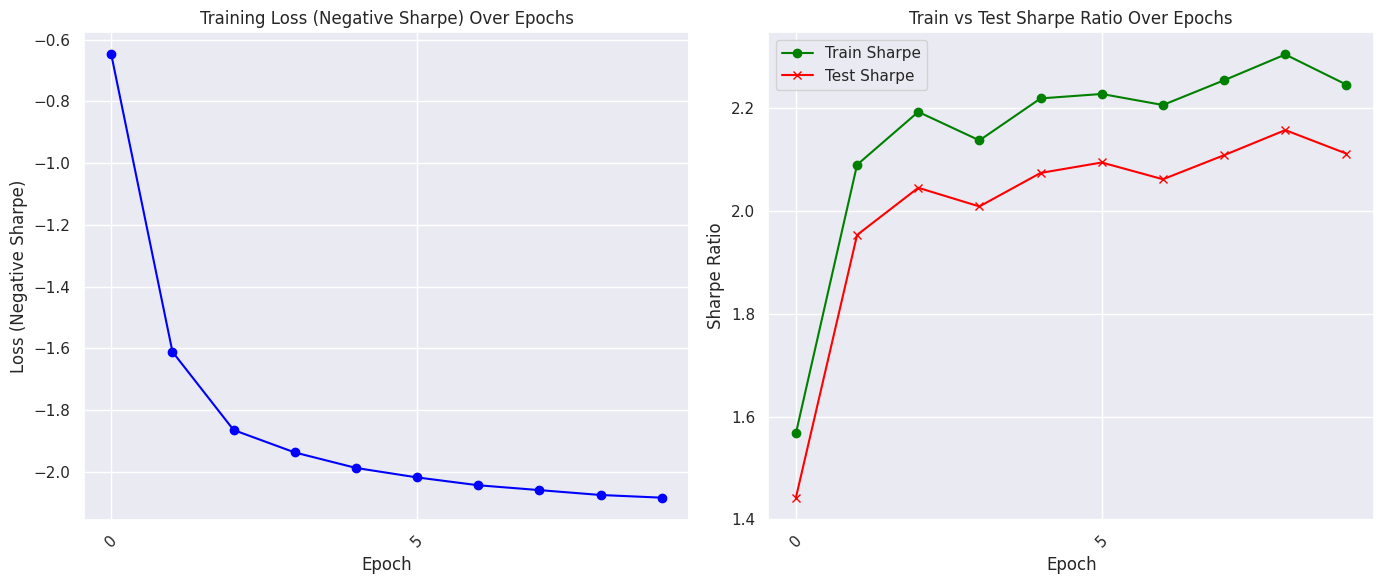

In [15]:
epochs = 10
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

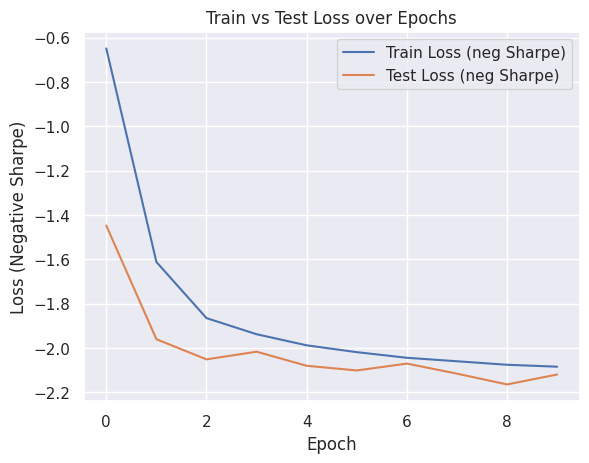

In [16]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)